In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def poly(x, *par):
    return np.polyval(par,x)

In [4]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [5]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [6]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    ylim = kwargs["ylim"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1940, 2031
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=ylim)

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()

In [7]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    ylim = kwargs["ylim"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim(ylim)
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [8]:
gdp_df = pd.read_csv("../gdp.csv", skiprows=4)

In [9]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10,NaN,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10,NaN,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.231983e+10,1.277622e+10,1.322814e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.514702e+10,1.527918e+10,NaN,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.154058e+09,NaN,NaN


In [10]:
world_df = gdp_df.query("`Country Code`=='WLD'")

In [11]:
world_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
257,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.369444e+12,1.425115e+12,1.530069e+12,1.648305e+12,1.805674e+12,1.966277e+12,...,7.516178e+13,7.731634e+13,7.945325e+13,7.521772e+13,7.636900e+13,8.130603e+13,8.643942e+13,8.773457e+13,NaN,NaN


In [12]:
world_df = world_df.loc[:, world_df.columns.isin([str(i) for i in range(1960,2020)])].T

In [13]:
year = world_df.index.to_numpy().astype(np.int).reshape(-1,1)
rate = world_df.iloc[:,0].to_numpy().reshape(-1,1)/100000000

In [14]:
test_ratio = 1 - 0.15
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[ 1.05094536e+04 -2.06634501e+07]
validate_rmse: 26748.49026432961 
 test_rmse: 218118.64069580528



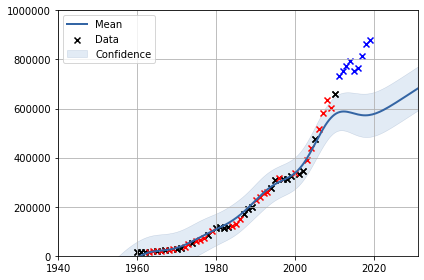

params:[ 1.27696983e+04 -2.51420011e+07]
validate_rmse: 29533.58160683436 
 test_rmse: 186880.28679304858



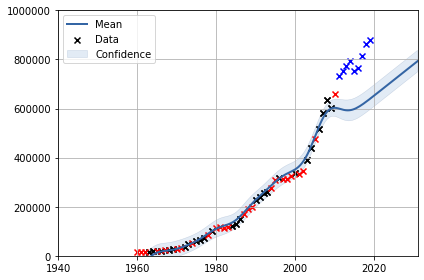

In [15]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=[0,1000000],
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/16 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[ 2.49629064e-02 -4.58189886e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 16447.91844010615 
 test_rmse: 1275510.5814870019



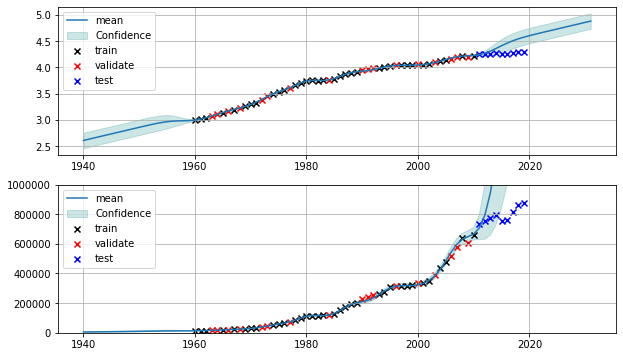

params:[ 2.48341183e-02 -4.55751103e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 13270.470442851984 
 test_rmse: 1234931.4257088318



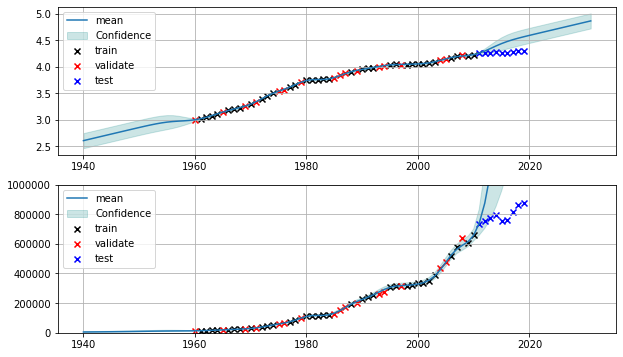

params:[ 2.51463061e-02 -4.61839023e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 7661.3982434246645 
 test_rmse: 1090998.0975377436



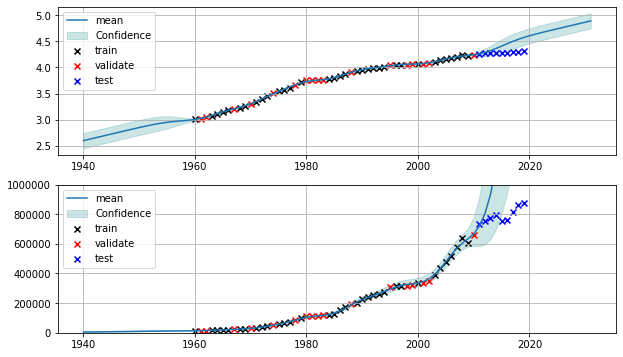

  6%|▋         | 1/16 [00:01<00:23,  1.56s/it]

params:[ 9.97077348e-02 -1.97203999e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 16242.413635068295 
 test_rmse: 105791.45600419602



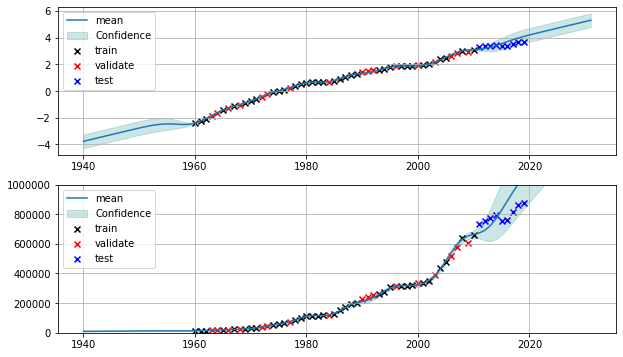

params:[ 1.01371138e-01 -2.00593794e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 12069.681783256126 
 test_rmse: 124108.06631622468



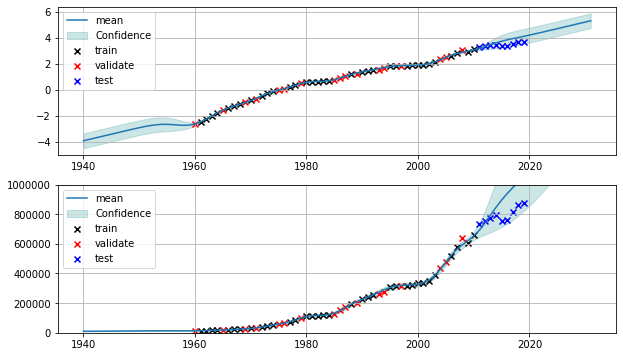

params:[ 1.01680493e-01 -2.01109785e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 9002.504827217921 
 test_rmse: 85862.0349135408



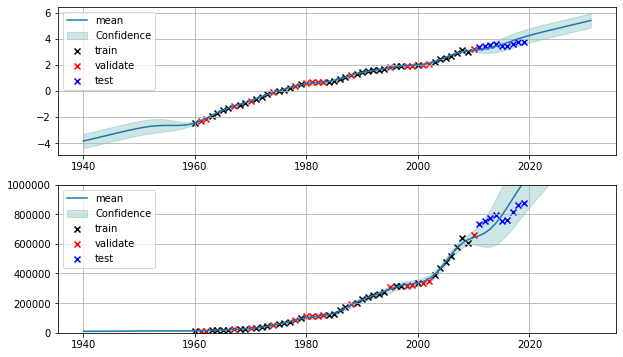

 12%|█▎        | 2/16 [00:03<00:23,  1.70s/it]

params:[ 9.86956946e-02 -1.96181708e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 16231.985857348007 
 test_rmse: 76414.45144024865



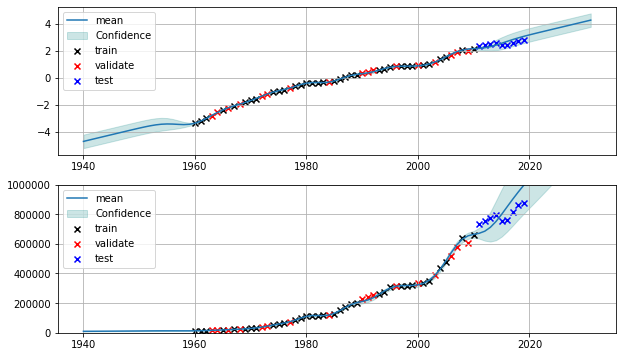

params:[ 9.81522375e-02 -1.95038176e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 11621.80206043365 
 test_rmse: 39713.556157561725



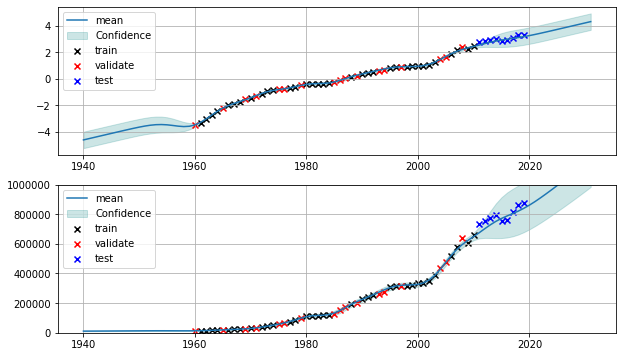

params:[ 1.00263339e-01 -1.99251985e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 9430.839708191672 
 test_rmse: 64402.89578788306



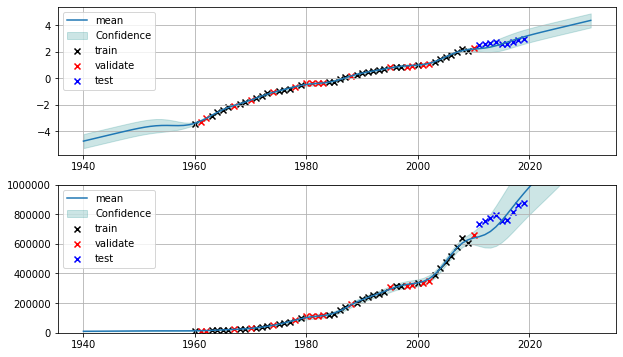

 19%|█▉        | 3/16 [00:04<00:21,  1.67s/it]

params:[ 9.96505869e-02 -1.97106547e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 16236.502545044339 
 test_rmse: 99488.42176058552



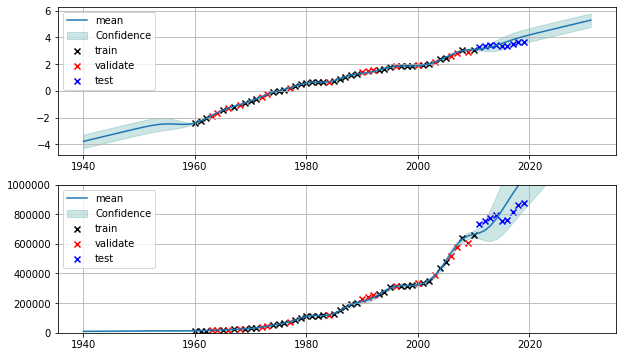

params:[ 1.01352696e-01 -2.00572296e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 12049.809362831713 
 test_rmse: 116616.17796582586



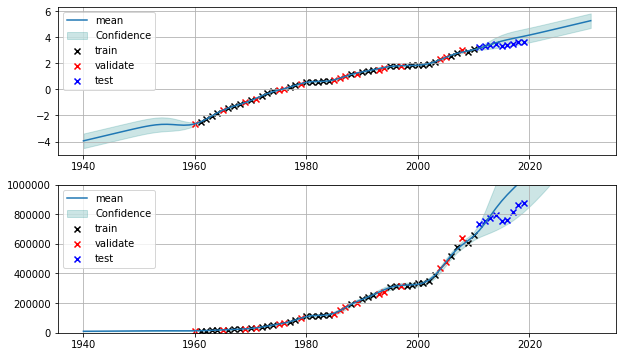

params:[ 1.01719205e-01 -2.01201869e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9002.436713618778 
 test_rmse: 81661.8773067273



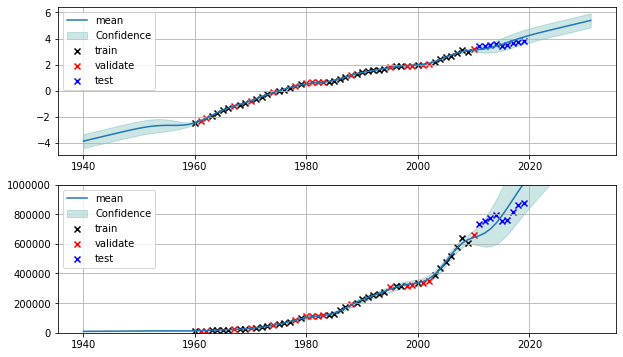

 25%|██▌       | 4/16 [00:06<00:20,  1.73s/it]

params:[ 9.96967904e-02 -1.99206733e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 16263.752487913225 
 test_rmse: 75195.32583146796



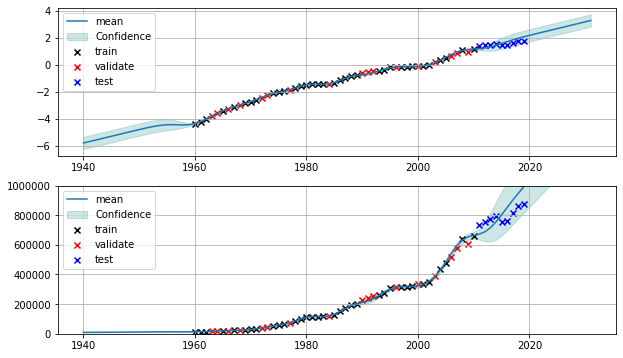

params:[ 9.66345806e-02 -1.92997777e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 11522.967572620133 
 test_rmse: 46476.23638490373



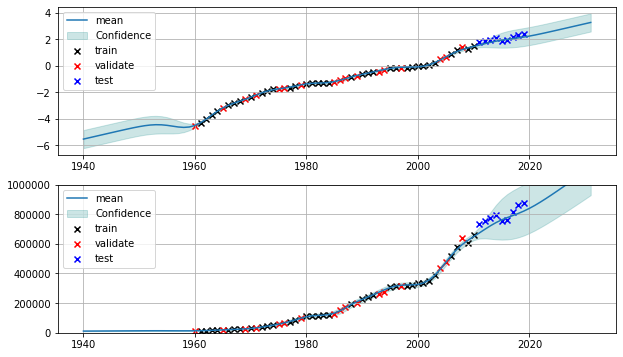

params:[ 9.86503679e-02 -1.96992745e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 9901.481474014048 
 test_rmse: 71430.7705064376



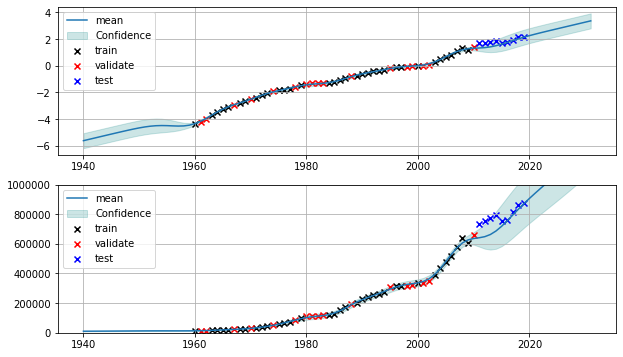

 31%|███▏      | 5/16 [00:08<00:18,  1.72s/it]

params:[ 9.62549416e-02 -1.90998243e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 15961.596138645284 
 test_rmse: 73170.76376990878



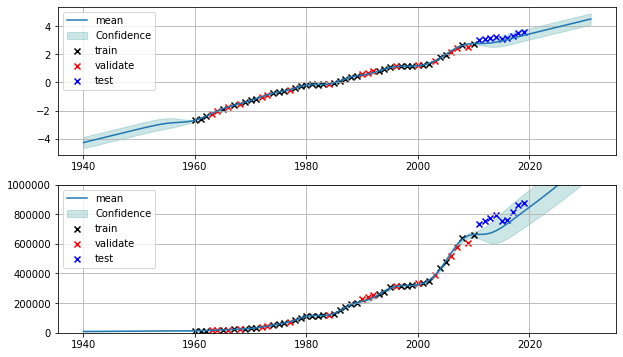

params:[ 9.31781917e-02 -1.84928536e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 11437.080886501262 
 test_rmse: 76378.6579547138



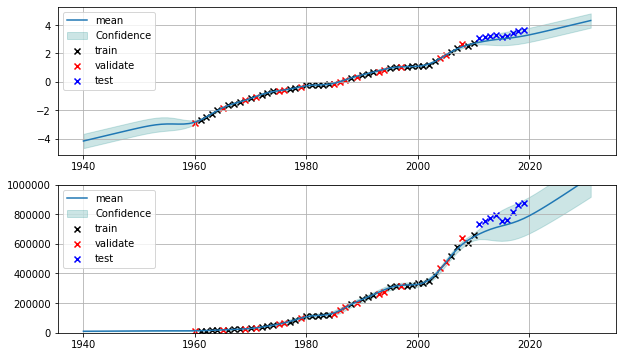

params:[ 9.81910034e-02 -1.94760166e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 10856.867089940248 
 test_rmse: 98227.11669434715



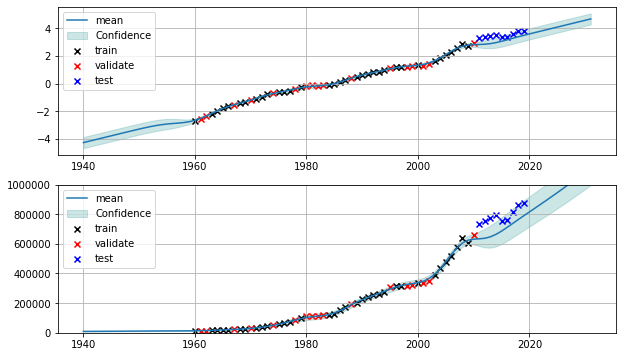

 38%|███▊      | 6/16 [00:10<00:16,  1.69s/it]

params:[ 9.81752760e-02 -1.95145259e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 16227.774371201624 
 test_rmse: 63693.370373538724



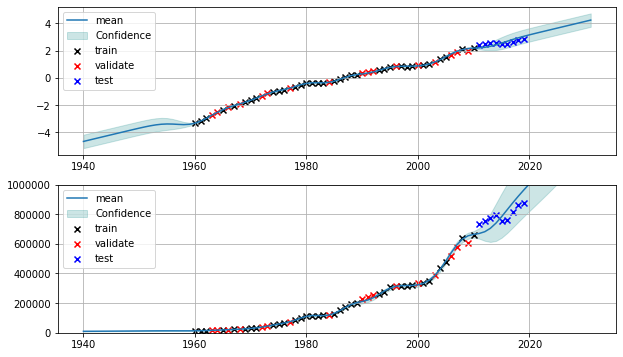

params:[ 9.80709822e-02 -1.94890752e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 11605.044846356759 
 test_rmse: 40814.48575900822



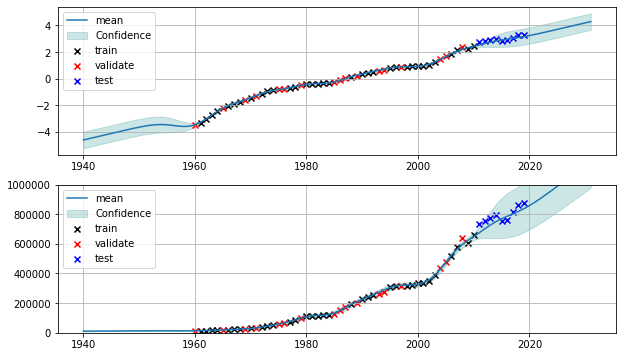

params:[ 9.93934313e-02 -1.97487393e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 9841.095031470904 
 test_rmse: 67122.37276303381



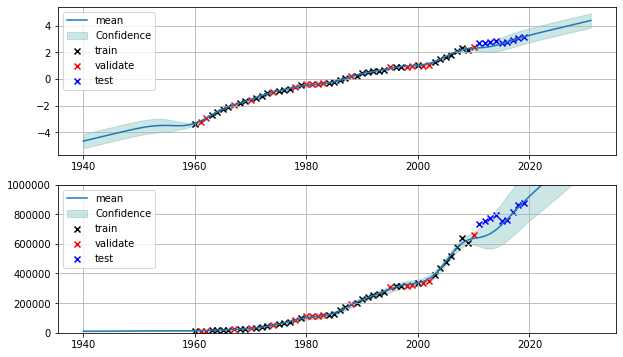

 44%|████▍     | 7/16 [00:11<00:15,  1.67s/it]

params:[ 9.96038599e-02 -1.97026223e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 16232.018115714409 
 test_rmse: 94801.7128732374



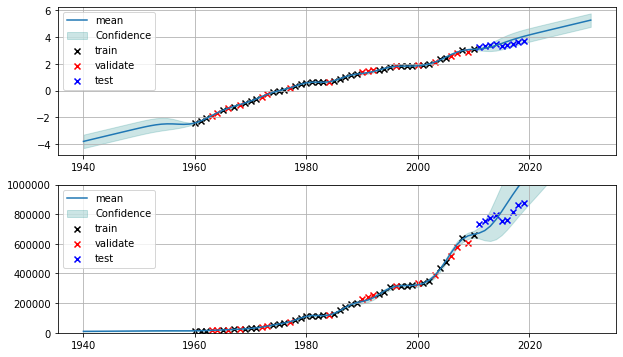

params:[ 1.01335659e-01 -2.00550224e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 12034.166644572633 
 test_rmse: 110965.47406788949



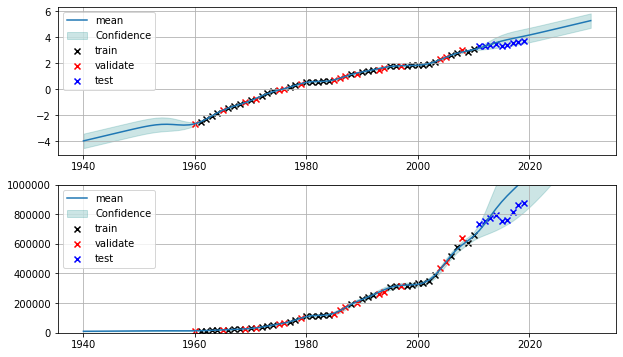

params:[ 1.01745756e-01 -2.01266431e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9003.913049062581 
 test_rmse: 78565.8721026225



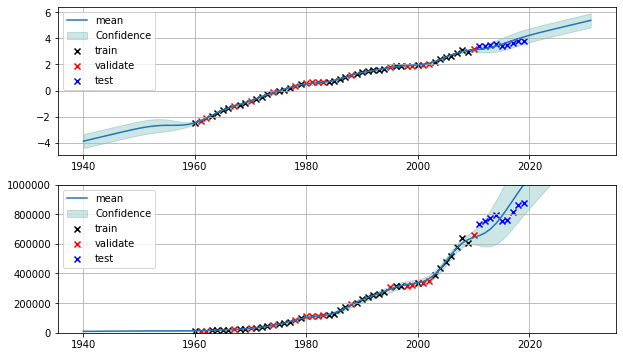

 50%|█████     | 8/16 [00:13<00:13,  1.65s/it]

params:[ 9.50572667e-02 -1.91515257e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 16000.374129640615 
 test_rmse: 92427.18943132012



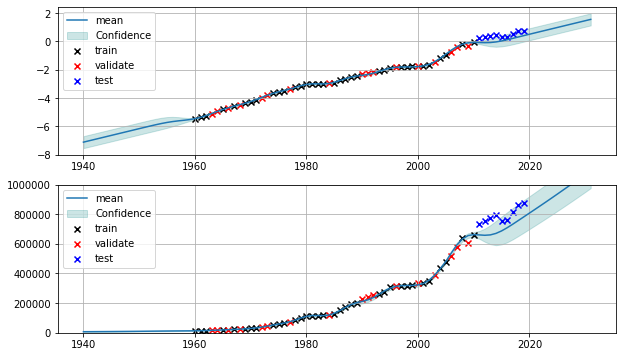

params:[ 9.67622522e-02 -1.94883726e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 11035.731809844001 
 test_rmse: 85369.95676634068



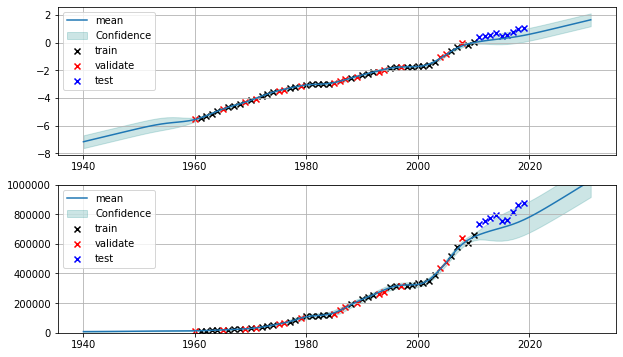

params:[ 9.84167888e-02 -1.98008955e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 11386.022577235597 
 test_rmse: 133982.44475787887



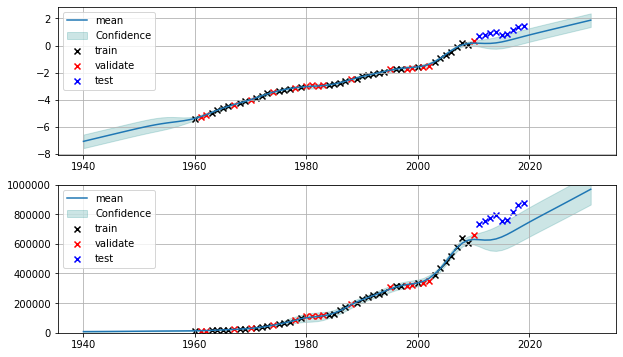

 56%|█████▋    | 9/16 [00:16<00:15,  2.16s/it]

params:[ 8.61146463e-02 -1.71765586e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 16380.6099372548 
 test_rmse: 169987.05287528943



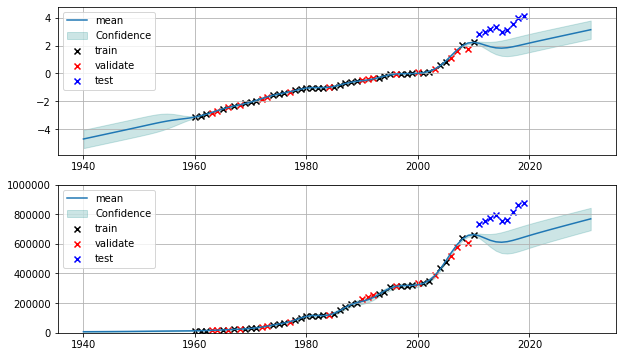

params:[ 8.62030536e-02 -1.71979553e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 12425.681202303269 
 test_rmse: 126621.93269032023



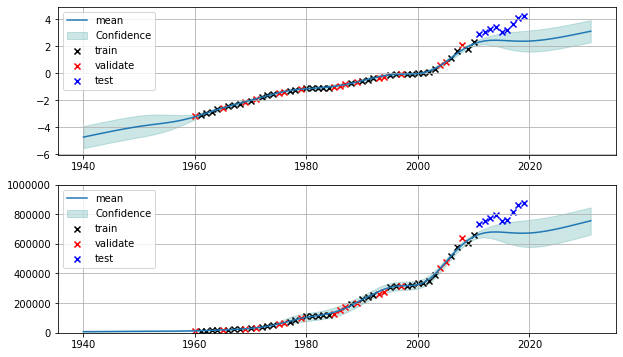

params:[ 8.84363096e-02 -1.76303155e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 11422.663806223982 
 test_rmse: 189114.23915484085



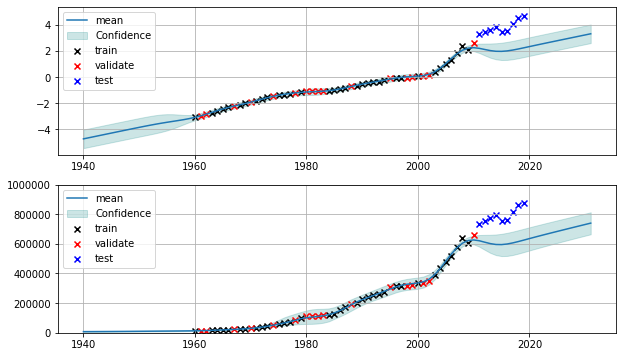

 62%|██████▎   | 10/16 [00:19<00:13,  2.22s/it]

params:[ 9.48389776e-02 -1.89599285e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 15905.475653891292 
 test_rmse: 118685.16402473403



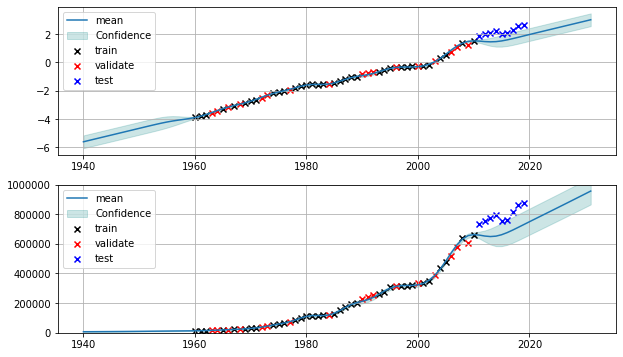

params:[ 9.02398820e-02 -1.80371975e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 11656.962198971061 
 test_rmse: 114419.49947639035



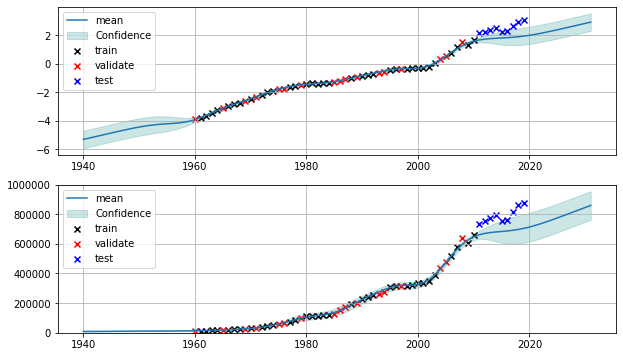

params:[ 9.40821767e-02 -1.87987445e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 11218.120626054495 
 test_rmse: 149029.51156844085



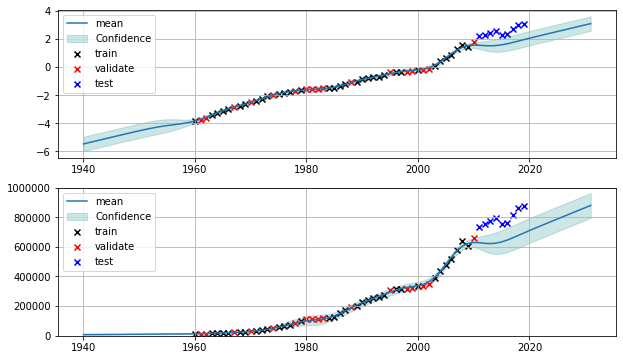

 69%|██████▉   | 11/16 [00:22<00:13,  2.66s/it]

params:[ 9.35573832e-02 -1.86016471e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 15972.309258744883 
 test_rmse: 123744.74582630525



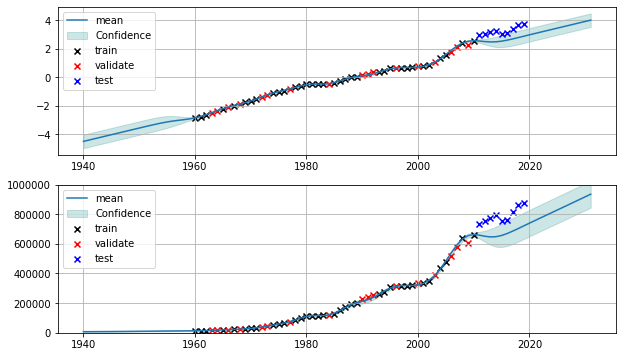

params:[ 9.22196952e-02 -1.83363154e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 11536.024620885488 
 test_rmse: 110180.71757552508



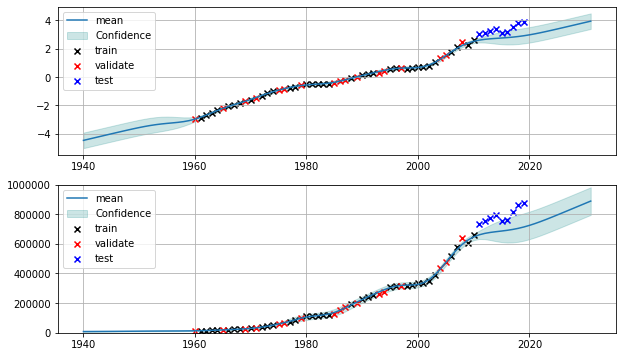

params:[ 9.27183263e-02 -1.84240891e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 11204.88469097561 
 test_rmse: 153694.3772909201



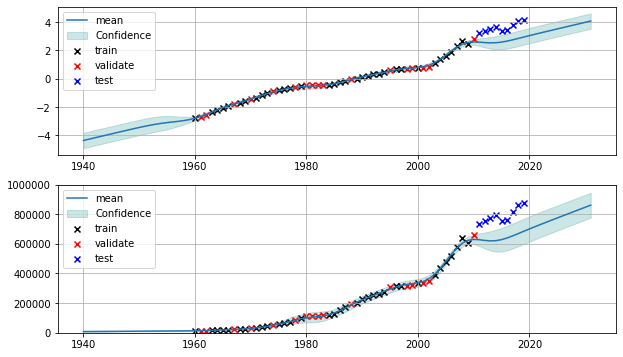

 75%|███████▌  | 12/16 [00:25<00:10,  2.64s/it]

params:[ 9.79870198e-02 -1.96199911e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 16008.222716532655 
 test_rmse: 62399.33185633372



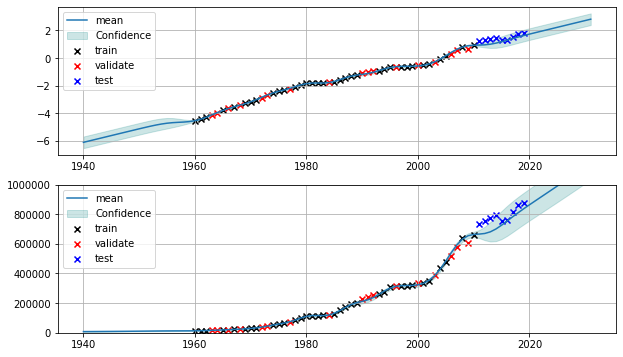

params:[ 9.88414977e-02 -1.97918744e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 11357.597446895548 
 test_rmse: 63906.543601408695



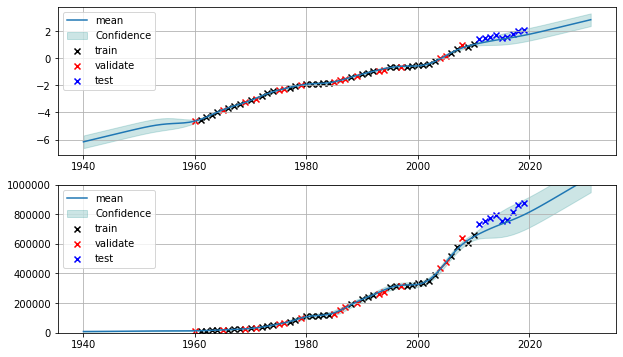

params:[ 9.92448707e-02 -1.98552228e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 10432.943200322683 
 test_rmse: 115510.64606535294



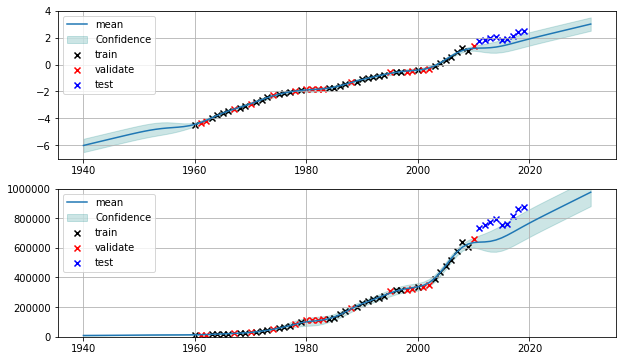

 81%|████████▏ | 13/16 [00:27<00:07,  2.46s/it]

params:[ 9.35574424e-02 -1.86016589e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 15972.308000476176 
 test_rmse: 123744.79158958617



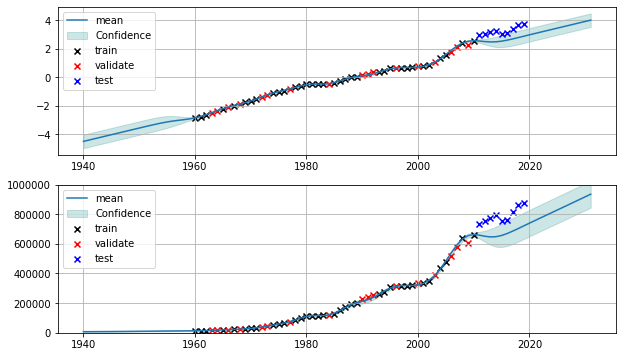

params:[ 9.22195497e-02 -1.83362865e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 11536.036344265163 
 test_rmse: 110180.95205001069



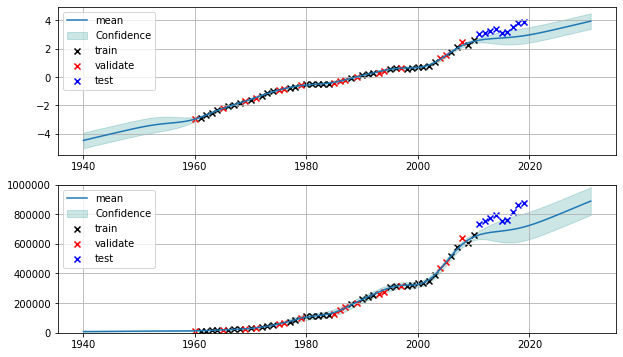

params:[ 9.27183601e-02 -1.84240958e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 11204.884184896822 
 test_rmse: 153694.26008564813



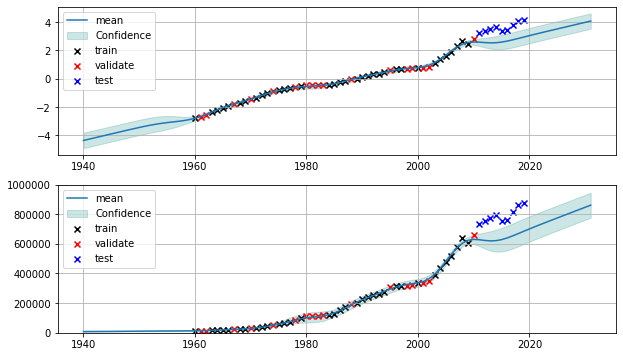

 88%|████████▊ | 14/16 [00:29<00:04,  2.40s/it]

params:[ 9.72576726e-02 -1.93720674e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 16151.277608421688 
 test_rmse: 65185.24891466462



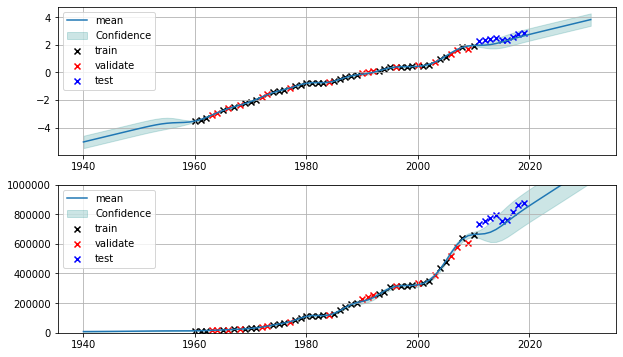

params:[ 9.68269262e-02 -1.92846003e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 11374.736638837594 
 test_rmse: 67487.74712708914



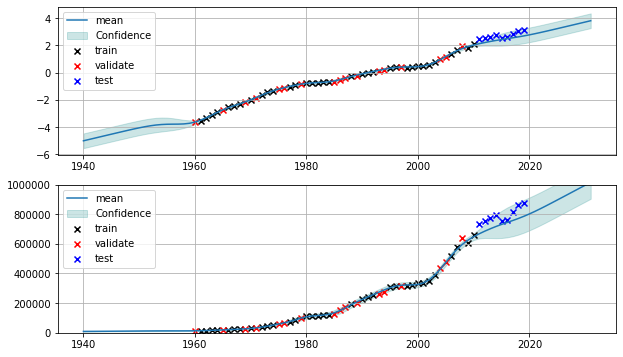

params:[ 9.71228283e-02 -1.93269299e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 10487.159995557697 
 test_rmse: 124104.84718140092



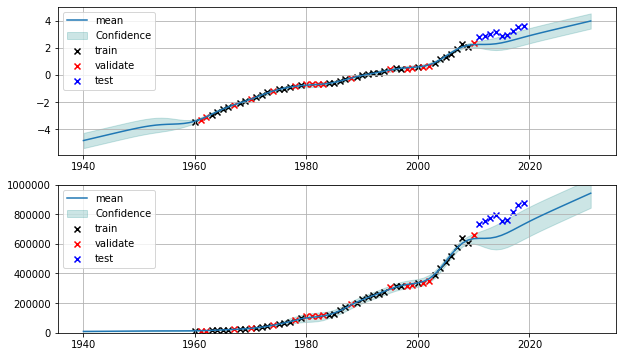

 94%|█████████▍| 15/16 [00:33<00:02,  2.74s/it]

params:[ 9.75868962e-02 -1.93381726e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 16176.271777733014 
 test_rmse: 62601.20292331646



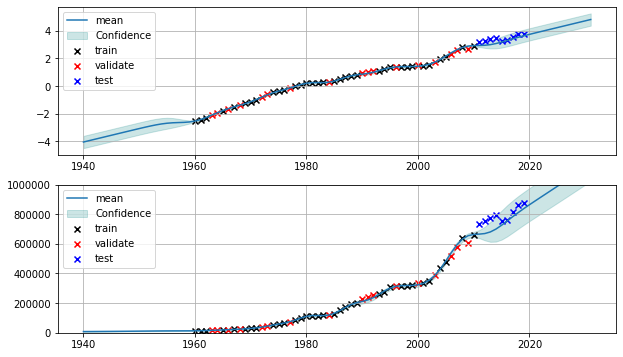

params:[ 9.99536868e-02 -1.98145045e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 11569.166821838897 
 test_rmse: 41123.11153863835



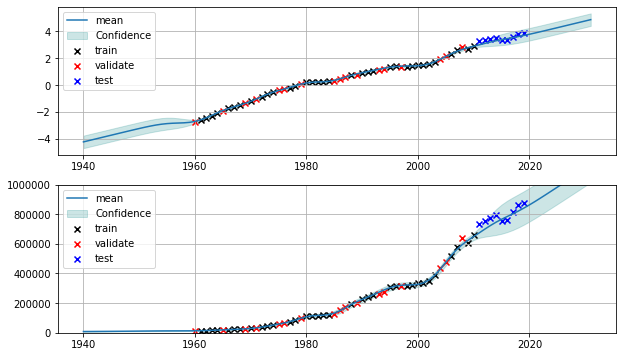

params:[ 1.01542137e-01 -2.01198840e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9574.465357066996 
 test_rmse: 71052.50080255374



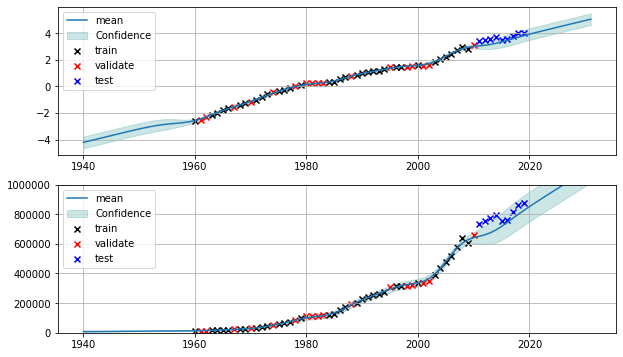

100%|██████████| 16/16 [00:36<00:00,  2.28s/it]


In [17]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":4,"n":[1],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=3, shuffle=True,
                     x_test=x_test,y_test=y_test,ylim=[0,1000000],
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    )